In [1]:
import scanpy as sc
data_dir = '../../dataset/Marshall2022High_human_sampled.h5ad'
adata = sc.read_h5ad(data_dir)
adata.X = adata.raw.X

In [2]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [3]:
adata.var['gene_id'] = adata.var.index
adata.var.index = adata.var['gene_name']

In [4]:
import scanpy as sc
import torch
from torch import nn
import lightning.pytorch as pl
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPAutoEncoder
from self_supervision.estimator.cellnet import EstimatorAutoEncoder

# 设置你的 .ckpt 文件路径
ckpt_path = "../../sc_pretrained/Pretrained Models/GPMask.ckpt"

# 模型参数
units_encoder = [512, 512, 256, 256, 64]
units_decoder = [256, 256, 512, 512]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 如果没有实际数据路径，可以设置为None

# 加载预训练模型
estim.model = MLPAutoEncoder.load_from_checkpoint(
    ckpt_path,
    gene_dim=19331,  # 根据你的数据调整
    batch_size=128,  # 根据你的需要调整
    units_encoder=units_encoder, 
    units_decoder=units_decoder,
    masking_strategy="random",  # 假设模型使用了随机掩码
    masking_rate=0.5,  # 根据需要调整
)

# 使用 GPU 进行评估（如果可用）
estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
estim.model

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [5]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)
n_classes

14

In [6]:
import pandas as pd
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
var_df

,feature_id,feature_name
0,ENSG00000186092,OR4F5
1,ENSG00000284733,OR4F29
2,ENSG00000284662,OR4F16
3,ENSG00000187634,SAMD11
4,ENSG00000188976,NOC2L
...,...,...
19326,ENSG00000288702,UGT1A3
19327,ENSG00000288705,UGT1A5
19328,ENSG00000182484,WASH6P
19329,ENSG00000288622,PDCD6-AHRR


In [7]:
all_genes = var_df['feature_name'].tolist()
all_genes

['OR4F5',
 'OR4F29',
 'OR4F16',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'HES4',
 'ISG15',
 'AGRN',
 'RNF223',
 'C1orf159',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'C1QTNF12',
 'UBE2J2',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'INTS11',
 'CPTP',
 'TAS1R3',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'CCNL2',
 'MRPL20',
 'ANKRD65',
 'TMEM88B',
 'VWA1',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'TMEM240',
 'SSU72',
 'FNDC10',
 'MIB2',
 'MMP23B',
 'CDK11B',
 'SLC35E2B',
 'CDK11A',
 'NADK',
 'GNB1',
 'CALML6',
 'TMEM52',
 'CFAP74',
 'GABRD',
 'PRKCZ',
 'FAAP20',
 'SKI',
 'MORN1',
 'RER1',
 'PEX10',
 'PLCH2',
 'PANK4',
 'HES5',
 'TNFRSF14',
 'PRXL2B',
 'MMEL1',
 'TTC34',
 'ACTRT2',
 'PRDM16',
 'ARHGEF16',
 'MEGF6',
 'TPRG1L',
 'WRAP73',
 'TP73',
 'CCDC27',
 'SMIM1',
 'LRRC47',
 'CEP104',
 'DFFB',
 'C1orf174',
 'AJAP1',
 'NPHP4',
 'KCNAB2',
 'CHD5',
 'RPL22',
 'RNF207',
 'ICMT',
 'HES3',
 'GPR153',
 'ACOT7',
 'HES2',
 'ESPN',
 'TNFRSF25',
 'PLEKHG5',
 'NOL9',
 'TAS1R1',
 'ZBTB48',
 'KLH

In [8]:
adata.var['gene_name']=adata.var.index
adata.var['gene_name']

gene_name
A1BG                                              A1BG
A1BG-AS1                                      A1BG-AS1
A1CF                                              A1CF
A2M                                                A2M
A2M-AS1                                        A2M-AS1
                                       ...            
ZZZ3                                              ZZZ3
MISP3                                            MISP3
ENSG00000234352.9                    ENSG00000234352.9
ARHGAP27P1-BPTFP1-KPNA2P3    ARHGAP27P1-BPTFP1-KPNA2P3
SBNO1-AS1                                    SBNO1-AS1
Name: gene_name, Length: 20299, dtype: category
Categories (25391, object): ['7SK_ENSG00000202198', 'A1BG', 'A1BG-AS1', 'A1CF', ..., 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3']

In [9]:
existing_genes = adata.var['gene_name']
existing_genes

gene_name
A1BG                                              A1BG
A1BG-AS1                                      A1BG-AS1
A1CF                                              A1CF
A2M                                                A2M
A2M-AS1                                        A2M-AS1
                                       ...            
ZZZ3                                              ZZZ3
MISP3                                            MISP3
ENSG00000234352.9                    ENSG00000234352.9
ARHGAP27P1-BPTFP1-KPNA2P3    ARHGAP27P1-BPTFP1-KPNA2P3
SBNO1-AS1                                    SBNO1-AS1
Name: gene_name, Length: 20299, dtype: category
Categories (25391, object): ['7SK_ENSG00000202198', 'A1BG', 'A1BG-AS1', 'A1CF', ..., 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3']

In [10]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes


匹配的基因数量: 15360
匹配的基因列表: {'abcb6', 'sema3e', 'naip', 'vwc2l', 'prxl2b', 'retsat', 'als2cl', 'lax1', 'pknox1', 'clcn5', 'rgs17', 'slu7', 'smim20', 'gins2', 'znf98', 'ears2', 'epha3', 'cpped1', 'polh', 'polr1b', 'crim1', 'xcl2', 'tfam', 'rogdi', 'ccdc8', 'tti2', 'dao', 'ebln2', 'hbg2', 'mipol1', 'gnao1', 'fbxw4', 'wfdc1', 'hdx', 'map7d3', 'sipa1l2', 'stat3', 'c19orf25', 'steep1', 'lsm12', 'apol6', 'uvssa', 'sirpb2', 'cyb5a', 'fam110c', 'slc17a7', 'lrrc37a', 'ca9', 'zwint', 'gpat3', 'ddx60', 'erich6', 'ncr3', 'mcee', 'vsig2', 'zc3h18', 'c19orf44', 'c9orf78', 'bbs10', 'armc12', 'chst3', 'pacs1', 'apol3', 'bmper', 'gas1', 'hspa5', 'prkci', 'efemp2', 'kcnj2', 'tnip3', 'rccd1', 'ifnar2', 'glud1', 'fam168b', 'nme8', 'bnip3l', 'tulp2', 'rai1', 'unc13d', 'exoc1', 'aff4', 'ints10', 'cnp', 'commd2', 'whamm', 'ube2j1', 'ppif', 'ifi44l', 'shisa6', 'wdr33', 'tcerg1l', 'kat2b', 'zfand4', 'kdm3a', 'epc2', 'pck2', 'alg8', 'crebl2', 'epha6', 'npm1', 'xpo5', 'rnf13', 'cdc37l1', 'spag17', 'nek8', 'ptger3', 

{'ensg00000272159.1',
 'acoxl-as1',
 'linc01440',
 'fam3d-as1',
 'linc01349',
 'linc02550',
 'ensg00000238280.2',
 'linc01215',
 'ensg00000272335.1',
 'znf781_ensg00000196381',
 'ensg00000224643.5',
 'oxr1-as1',
 'linc00543',
 'ensg00000268107.6',
 'linc01003',
 'fam66a',
 'ensg00000275210.1',
 'linc02306',
 'ensg00000224216.1',
 'tm4sf19-as1',
 'rere-as1',
 'hcg14',
 'linc01579',
 'ensg00000227482.1',
 'kdsr-dt',
 'linc03048',
 'linc01473',
 'ensg00000229308.1',
 'ensg00000261130.5',
 'ensg00000226043.2',
 'linc01676',
 'ensg00000234810.4',
 'dicer1-as1',
 'ensg00000269289.6',
 'linc02894',
 'hmgn3-as1',
 'ensg00000225885.7',
 'ensg00000237153.4',
 'ensg00000261170.2',
 'garin5a',
 'ensg00000268218.1',
 'ensg00000260430.2',
 'ensg00000268870.1',
 'anxa2r-ot1',
 'ensg00000256100.1',
 'linc00596',
 'linc01517',
 'ensg00000259359.2',
 'ensg00000268288.1',
 'bet1-as1',
 'linc00963',
 'faup4',
 'ensg00000272735.2',
 'iqsec3-as1',
 'ensg00000250706.1',
 'linc02237',
 'linc00534',
 'erbin-dt

In [11]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
gene_to_index

{'or4f5': 0,
 'or4f29': 1,
 'or4f16': 2,
 'samd11': 3,
 'noc2l': 4,
 'klhl17': 5,
 'plekhn1': 6,
 'perm1': 7,
 'hes4': 8,
 'isg15': 9,
 'agrn': 10,
 'rnf223': 11,
 'c1orf159': 12,
 'ttll10': 13,
 'tnfrsf18': 14,
 'tnfrsf4': 15,
 'sdf4': 16,
 'b3galt6': 17,
 'c1qtnf12': 18,
 'ube2j2': 19,
 'scnn1d': 20,
 'acap3': 21,
 'pusl1': 22,
 'ints11': 23,
 'cptp': 24,
 'tas1r3': 25,
 'dvl1': 26,
 'mxra8': 27,
 'aurkaip1': 28,
 'ccnl2': 29,
 'mrpl20': 30,
 'ankrd65': 31,
 'tmem88b': 32,
 'vwa1': 33,
 'atad3c': 34,
 'atad3b': 35,
 'atad3a': 36,
 'tmem240': 37,
 'ssu72': 38,
 'fndc10': 39,
 'mib2': 40,
 'mmp23b': 41,
 'cdk11b': 42,
 'slc35e2b': 43,
 'cdk11a': 44,
 'nadk': 45,
 'gnb1': 46,
 'calml6': 47,
 'tmem52': 48,
 'cfap74': 49,
 'gabrd': 50,
 'prkcz': 51,
 'faap20': 52,
 'ski': 53,
 'morn1': 54,
 'rer1': 55,
 'pex10': 56,
 'plch2': 57,
 'pank4': 58,
 'hes5': 59,
 'tnfrsf14': 60,
 'prxl2b': 61,
 'mmel1': 62,
 'ttc34': 63,
 'actrt2': 64,
 'prdm16': 65,
 'arhgef16': 66,
 'megf6': 67,
 'tprg1l': 68

In [12]:
only_in_all_genes = all_genes_set - adata_genes_set

only_in_adata_genes = adata_genes_set - all_genes_set

# 输出结果
print(f"仅在 all_genes 中存在的基因数量: {len(only_in_all_genes)}")
print(f"仅在 all_genes 中存在的基因: {only_in_all_genes}")

print(f"仅在 adata_genes 中存在的基因数量: {len(only_in_adata_genes)}")
print(f"仅在 adata_genes 中存在的基因: {only_in_adata_genes}")


仅在 all_genes 中存在的基因数量: 3971
仅在 all_genes 中存在的基因: {'cst2', 'npy4r2', 'hspb3', 'mmp8', 'poted', 'six6', 'dsg3', 'lce1c', 'tex53', 'ccdc177', 'cylc1', 'golga8f', 'chrnd', 'cdc14c', 'dspp', 'or2f1', 'gpx6', 'crybb2', 'ncoa4', 'krtap12-4', 'nutm2e', 'krtap22-1', 'mtrnr2l11', 'trim67', 'krbox1', 'fgl1', 'adig', 'or5k4', 'uqcr11', 'avpr1b', 'lrrc30', 'krt1', 'slitrk1', 'prss57', 'slc1a7', 'bscl2', 'tfap2e', 'h2bc17', 'tex19', 'tmem89', 'slc34a1', 'gtsf1l', 'tlx3', 'defb135', 'aqp12b', 'crygd', 'scygr5', 'chrna3', 'znf84', 'cyp3a4', 'or10r2', 'tmem151a', 'crabp1', 'pnma6f', 'cfc1b', 'mybphl', 'usp29', 'f2', 'ssu72p2', 'gabrg2', 'c11orf49', 'fam187b', 'golga8h', 'catsperz', 'hgh1', 'trim31', 'zp4', 'nphp3-acad11', 'sry', 'npy', 'or4c12', 'prr33', 'or1i1', 'usp17l3', 'or56b4', 'pmf1-bglap', 'krtap12-3', 'pcdhga11', 'rnf115', 'magea3', 'or8u3', 'fam90a23p', 'f11', 'golga6c', 'cabp5', 'c7orf61', 'c17orf50', 'rfpl1', 'ftmt', 'gage2a', 'h2bc9', 'ramacl', 'poteg', 'slc25a52', 'pip', 'semg1', 'tgfbr3l

In [13]:
import numpy as np
from scipy.sparse import csr_matrix

# Initialize a mapping from gene names in adata to their column indices
adata_gene_to_index = {gene: idx for idx, gene in enumerate(adata_genes_lower)}

# Create an array to map adata.X column indices to new_data column indices
adata_to_new_data_indices = -1 * np.ones(adata.X.shape[1], dtype=int)
for idx, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        adata_to_new_data_indices[idx] = gene_to_index[gene]



# Extract data from adata.X without converting it to a dense array
data = adata.X.data
indices = adata.X.indices
indptr = adata.X.indptr

# Map the column indices to the new indices in new_data
mapped_indices = adata_to_new_data_indices[indices]

# Filter out entries where the mapping is invalid (-1)
valid_entries = mapped_indices != -1
new_data_values = data[valid_entries]
new_data_indices = mapped_indices[valid_entries]

# Build the new indptr array for the new_data matrix
new_indptr = np.zeros(adata.X.shape[0] + 1, dtype=int)


for i in range(adata.X.shape[0]):
    row_start = indptr[i]
    row_end = indptr[i + 1]
    valid_count = np.sum(valid_entries[row_start:row_end])
    new_indptr[i + 1] = new_indptr[i] + valid_count


# Construct the new_data sparse matrix
new_data = csr_matrix(
    (new_data_values, new_data_indices, new_indptr),
    shape=(adata.X.shape[0], len(all_genes)),
    dtype=np.float32
)
new_data = new_data.toarray()

In [14]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split


label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42
X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

cuda


MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [15]:
# 6. 微调模型，仅微调 encoder 的最后两层，其他层参数冻结
for param in estim.model.encoder.parameters():
    param.requires_grad = False  # 冻结所有层

# 解冻最后两层
for param in list(estim.model.encoder.parameters())[-5:]:
    param.requires_grad = True

In [16]:
from torch.optim import AdamW
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [17]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7. 微调模型
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.encoder(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.encoder(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [18]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss} at epoch {epoch+1}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")


Epoch 1, Train Loss: 1.5878521108190744, Validation Loss: 1.2700124640035404
Validation loss improved to 1.2700124640035404 at epoch 1, resetting patience.


Epoch 2, Train Loss: 1.352583035932795, Validation Loss: 1.2557118430521816
Validation loss improved to 1.2557118430521816 at epoch 2, resetting patience.


Epoch 3, Train Loss: 1.3359995672928353, Validation Loss: 1.2453169986535022
Validation loss improved to 1.2453169986535022 at epoch 3, resetting patience.


Epoch 4, Train Loss: 1.324395222557161, Validation Loss: 1.2489346712121467
No improvement in validation loss. Patience counter: 1/20


Epoch 5, Train Loss: 1.3166442652321055, Validation Loss: 1.2109755836956875
Validation loss improved to 1.2109755836956875 at epoch 5, resetting patience.


Epoch 6, Train Loss: 1.3119563029232006, Validation Loss: 1.2075546917757152
Validation loss improved to 1.2075546917757152 at epoch 6, resetting patience.


Epoch 7, Train Loss: 1.3082993053589567, Validation Loss: 1.208754185816688
No improvement in validation loss. Patience counter: 1/20


Epoch 8, Train Loss: 1.3037783752137744, Validation Loss: 1.2095943339063093
No improvement in validation loss. Patience counter: 2/20


Epoch 9, Train Loss: 1.2999758604584244, Validation Loss: 1.2103560160121647
No improvement in validation loss. Patience counter: 3/20


Epoch 10, Train Loss: 1.2998401585090924, Validation Loss: 1.1993652308156706
Validation loss improved to 1.1993652308156706 at epoch 10, resetting patience.


Epoch 11, Train Loss: 1.2958621901146392, Validation Loss: 1.2028377132393173
No improvement in validation loss. Patience counter: 1/20


Epoch 12, Train Loss: 1.2958518338227685, Validation Loss: 1.1962702025734417
Validation loss improved to 1.1962702025734417 at epoch 12, resetting patience.


Epoch 13, Train Loss: 1.2933021421835114, Validation Loss: 1.212707551452221
No improvement in validation loss. Patience counter: 1/20


Epoch 14, Train Loss: 1.2900535997272387, Validation Loss: 1.190662655502699
Validation loss improved to 1.190662655502699 at epoch 14, resetting patience.


Epoch 15, Train Loss: 1.2869822612735287, Validation Loss: 1.1874930867086655
Validation loss improved to 1.1874930867086655 at epoch 15, resetting patience.


Epoch 16, Train Loss: 1.2856901865888346, Validation Loss: 1.194794693829324
No improvement in validation loss. Patience counter: 1/20


Epoch 17, Train Loss: 1.2873602530114647, Validation Loss: 1.20196607186331
No improvement in validation loss. Patience counter: 2/20


Epoch 18, Train Loss: 1.2851946984521005, Validation Loss: 1.1972327910328364
No improvement in validation loss. Patience counter: 3/20


Epoch 19, Train Loss: 1.2846971658699873, Validation Loss: 1.1883256466467798
No improvement in validation loss. Patience counter: 4/20


Epoch 20, Train Loss: 1.2843824251500904, Validation Loss: 1.181358708589563
Validation loss improved to 1.181358708589563 at epoch 20, resetting patience.


Epoch 21, Train Loss: 1.2815049664777753, Validation Loss: 1.1772645533932329
Validation loss improved to 1.1772645533932329 at epoch 21, resetting patience.


Epoch 22, Train Loss: 1.2792942086774723, Validation Loss: 1.1964347817321523
No improvement in validation loss. Patience counter: 1/20


Epoch 23, Train Loss: 1.2786635521227079, Validation Loss: 1.1845862404995056
No improvement in validation loss. Patience counter: 2/20


Epoch 24, Train Loss: 1.2791191645095452, Validation Loss: 1.2019096251347618
No improvement in validation loss. Patience counter: 3/20


Epoch 25, Train Loss: 1.27763323023506, Validation Loss: 1.204952171628509
No improvement in validation loss. Patience counter: 4/20


Epoch 26, Train Loss: 1.280358154436579, Validation Loss: 1.1843744937277518
No improvement in validation loss. Patience counter: 5/20


Epoch 27, Train Loss: 1.2778283253933624, Validation Loss: 1.1755368859282036
Validation loss improved to 1.1755368859282036 at epoch 27, resetting patience.


Epoch 28, Train Loss: 1.2781934934011674, Validation Loss: 1.199482473999403
No improvement in validation loss. Patience counter: 1/20


Epoch 29, Train Loss: 1.277310122308508, Validation Loss: 1.1796064611294823
No improvement in validation loss. Patience counter: 2/20


Epoch 30, Train Loss: 1.2770132759580293, Validation Loss: 1.1861250112407016
No improvement in validation loss. Patience counter: 3/20


Epoch 31, Train Loss: 1.2770017582547992, Validation Loss: 1.1853627263087232
No improvement in validation loss. Patience counter: 4/20


Epoch 32, Train Loss: 1.2763020199773756, Validation Loss: 1.2022811507726732
No improvement in validation loss. Patience counter: 5/20


Epoch 33, Train Loss: 1.2750027254299618, Validation Loss: 1.183237307444568
No improvement in validation loss. Patience counter: 6/20


Epoch 34, Train Loss: 1.271920957921844, Validation Loss: 1.1847467953559911
No improvement in validation loss. Patience counter: 7/20


Epoch 35, Train Loss: 1.2747031971736453, Validation Loss: 1.1813331093833346
No improvement in validation loss. Patience counter: 8/20


Epoch 36, Train Loss: 1.2729382165087082, Validation Loss: 1.1860197632798652
No improvement in validation loss. Patience counter: 9/20


Epoch 37, Train Loss: 1.273376168275777, Validation Loss: 1.1827898875796965
No improvement in validation loss. Patience counter: 10/20


Epoch 38, Train Loss: 1.2719178997124199, Validation Loss: 1.188747312785325
No improvement in validation loss. Patience counter: 11/20


Epoch 39, Train Loss: 1.2731243778827352, Validation Loss: 1.1733791090865835
Validation loss improved to 1.1733791090865835 at epoch 39, resetting patience.


Epoch 40, Train Loss: 1.2738673497798605, Validation Loss: 1.177396211861434
No improvement in validation loss. Patience counter: 1/20


Epoch 41, Train Loss: 1.2714868948879223, Validation Loss: 1.1852140692173023
No improvement in validation loss. Patience counter: 2/20


Epoch 42, Train Loss: 1.2719488900044926, Validation Loss: 1.1810863825947187
No improvement in validation loss. Patience counter: 3/20


Epoch 43, Train Loss: 1.2739923048237696, Validation Loss: 1.1763244615911872
No improvement in validation loss. Patience counter: 4/20


Epoch 44, Train Loss: 1.2717924583722229, Validation Loss: 1.1790156330542543
No improvement in validation loss. Patience counter: 5/20


Epoch 45, Train Loss: 1.270912856985327, Validation Loss: 1.191060307184102
No improvement in validation loss. Patience counter: 6/20


Epoch 46, Train Loss: 1.2715952477644321, Validation Loss: 1.1824065633294707
No improvement in validation loss. Patience counter: 7/20


Epoch 47, Train Loss: 1.2724384241041065, Validation Loss: 1.1744667743619583
No improvement in validation loss. Patience counter: 8/20


Epoch 48, Train Loss: 1.2712390715690256, Validation Loss: 1.17632859323827
No improvement in validation loss. Patience counter: 9/20


Epoch 49, Train Loss: 1.2725472104634297, Validation Loss: 1.1743120534160125
No improvement in validation loss. Patience counter: 10/20


Epoch 50, Train Loss: 1.270842856514369, Validation Loss: 1.1819473824229851
No improvement in validation loss. Patience counter: 11/20


Epoch 51, Train Loss: 1.2700997094414364, Validation Loss: 1.1840035553792077
No improvement in validation loss. Patience counter: 12/20


Epoch 52, Train Loss: 1.2719313707865874, Validation Loss: 1.1773318289580503
No improvement in validation loss. Patience counter: 13/20


Epoch 53, Train Loss: 1.2697185616890994, Validation Loss: 1.17593514919281
No improvement in validation loss. Patience counter: 14/20


Epoch 54, Train Loss: 1.270519217300027, Validation Loss: 1.1828924725405978
No improvement in validation loss. Patience counter: 15/20


Epoch 55, Train Loss: 1.2678588953168564, Validation Loss: 1.1775176844325677
No improvement in validation loss. Patience counter: 16/20


Epoch 56, Train Loss: 1.2680786969339133, Validation Loss: 1.1788235289790618
No improvement in validation loss. Patience counter: 17/20


Epoch 57, Train Loss: 1.270667479215294, Validation Loss: 1.1749996828241935
No improvement in validation loss. Patience counter: 18/20


Epoch 58, Train Loss: 1.270656990192429, Validation Loss: 1.1815421053018615
No improvement in validation loss. Patience counter: 19/20


Epoch 59, Train Loss: 1.2701071099977892, Validation Loss: 1.1932053331515236
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 59.
Loaded best model weights based on validation loss.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


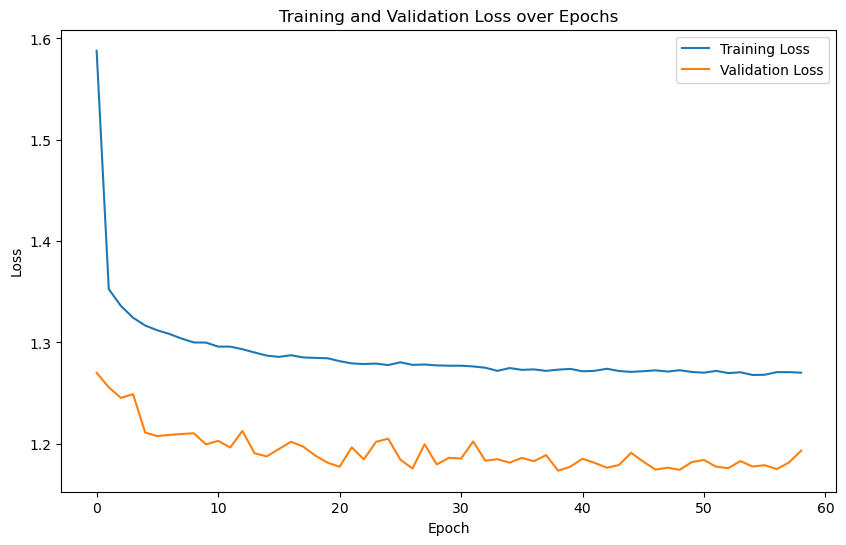

In [19]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig(f'../loss_curve_fig/slide_seq_human_kidney_gp_mask_finetune_full_loss_curve{random_seed}.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig(f'../loss_curve_fig/slide_seq_human_kidney_gp_mask_finetune_full_loss_curve{random_seed}.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()


In [20]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.encoder(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.encoder(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [21]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.591374703087886
Weighted F1 Score: 0.5589165060380544
Macro F1 Score: 0.2874800266010652
Random Guess Accuracy: 0.2927884776016484
                                                           precision    recall  f1-score   support

                          blood vessel smooth muscle cell       0.24      0.14      0.18       852
                                         endothelial cell       0.62      0.82      0.71     13511
                 kidney collecting duct intercalated cell       0.35      0.21      0.26      1032
                    kidney collecting duct principal cell       0.67      0.58      0.62      2040
          kidney distal convoluted tubule epithelial cell       0.49      0.33      0.39       618
                                     kidney granular cell       0.29      0.05      0.08       105
                           kidney interstitial fibroblast       0.29      0.08      0.12       781
kidney loop of Henle thick ascending limb epith

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [22]:
with torch.no_grad():
    new_data_tensor = torch.tensor(new_data).float().to(device)
    SSL_embeddings = estim.model.encoder(new_data_tensor).detach().cpu().numpy()
new_adata = sc.read_h5ad(data_dir)
new_adata.obsm[f'SSL_GP_FT_{random_seed}'] = SSL_embeddings
new_adata.uns[f'GP_FT_y_test_{random_seed}'] = y_test
new_adata.uns[f'GP_FT_predictions_{random_seed}'] = predictions
new_adata.uns[f'GP_FT_target_names_{random_seed}'] = label_encoder.classes_
new_adata.uns[f'GP_FT_train_loss_{random_seed}'] = train_losses
new_adata.uns[f'GP_FT_val_loss_{random_seed}'] = val_losses
new_adata.write_h5ad(data_dir)

In [23]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "slide_seq_human_kidney_GP_mask_fine_tune_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicor_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['slide_seq_human_kidney'],
    'method': [re.search(r'kidney_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micor_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micor_f1
1.588	1.270	39	1.173	0.287	0.559	0.591
